## **Clustering Neighborhoods in Istanbul**





---



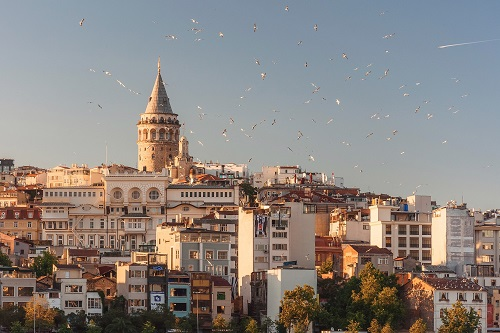

## Table of Contents:
* [1. Introduction/Business Problem](#chapter1)
* [2. Data](#chapter2)
* [3. Methodology](#chapter3)
* [4. Results](#chapter4)
* [5. Discussion](#chapter5)
* [6. Conclusion](#chapter6)

# 1. Introduction/Business Problem <a class="anchor" id="chapter1"></a>

Istanbul is the largest city of Turkey, with over 15 million residents. It's also, the world's largest fifteenth city. The high population rate is the result of having more economical, cultural and social opportunities than the rest of the country, but this also brings some struggles for residents of the city. One of them is finding an appropriate house. Location of the house is very important for the home seekers, in terms of its nearness to places like public transportation hubs, schools, hospitals, etc. For each resident, it is hard to find the right nighboorhood for his/her preferences.

In this project, finding the best neighboorhood for different type houseseekers in İstanbul is examined by clustering the neighborhoods. Of course, features like price, m2 of house are also important, but in this project location based features are studied for segmentation analysis.

# 2. Data <a class="anchor" id="chapter2"></a>

Data sources for Clustering Neighborhoods in Istanbul are as follow;

1.   Neighborhood list of İstanbul, [Wikipedia](https://tr.wikipedia.org/wiki/%C4%B0stanbul%27un_mahalleleri).  

  All Borough and neighborhoods list of Istanbul is given in the Wikipedia page above. The list will be taken by the help of **Requests** and **BeautifulSoup** libraries. Next,  **geopy** library will be used to get the latitude and longitude values of Neighborhoods

2.   Foursquare API

    Foursquare API will be used to explore each neighborhood by its latitude and longitude information. **explore** endpoint query will be used to get the list of venues in the neighborhood. List of venue categories provided by Foursquare can be reached at, [Foursquare Venue Category List](https://). Most common 10 venue categories for each neighborhood will be analyzed for clustering.
    


Necessary libraries are imported

In [4]:
import requests as req
from bs4 import BeautifulSoup as bs
import pandas as pd
import numpy as np
import json 
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
from pandas.io.json import json_normalize 
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
# import k-means from clustering stage
from sklearn.cluster import KMeans
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


## 2.1 Data Extraction 

### 2.1.1 Get Neighborhoods from Wikipedia

In [ ]:
url = "https://tr.wikipedia.org/wiki/%C4%B0stanbul%27un_mahalleleri"
r = req.get(url)
soup = bs(r.content)

In [ ]:
borough_tag = soup.find("div", attrs={"class":"div-col columns column-count column-count-3"}).find_all("a")
borough_list = [b.text for b in borough_tag if b.text != '[3]']

In [ ]:
neigh_tag = soup.find_all("li")
neigh_text = [a.find("a").get_text() for a in neigh_tag if a.find("a")]

In [ ]:
neigh_text[119], neigh_text[958] #first and last lines of neighborhood lists

('Burgazada, Adalar', 'Yeşiltepe, Zeytinburnu')

In [ ]:
neigh_text_filter = neigh_text[119:959]

In [ ]:
neigh_text_comma = [n for n in neigh_text_filter if "," in n ]
neigh_text_wo_comma = [n for n in neigh_text_filter if "," not in n ]

In [ ]:
neigh_text_comma

In [ ]:
all_info=[]
for row in neigh_text_comma:
    cell = {}
    neigh_bor = row.split(",")
    cell['Borough'] = neigh_bor[1].strip()
    cell['Neighborhood'] = neigh_bor[0].strip()
    all_info.append(cell)


for i in range(0,11):
  cell={}
  cell['Borough']="Bahçelievler"
  cell['Neighborhood'] = neigh_text_wo_comma[i]
  all_info.append(cell)
for i in range(11,50):
  cell={}
  cell['Borough']="Çatalca"
  cell['Neighborhood'] = neigh_text_wo_comma[i]
  all_info.append(cell)
for i in range(50,93):
  cell={}
  cell['Borough']="Esenyurt"
  cell['Neighborhood'] = neigh_text_wo_comma[i]
  all_info.append(cell)


In [ ]:
for i in range(len(all_info)):
  if all_info[i]["Borough"] in all_info[i]["Neighborhood"]:
    print(all_info[i]["Borough"],  all_info[i]["Neighborhood"])

Arnavutköy Arnavutköy İmrahor
Arnavutköy Arnavutköy İslambey
Arnavutköy Arnavutköy Merkez
Arnavutköy Arnavutköy Yavuzselim
Başakşehir Başakşehir
Bahçelievler Bahçelievler


In [ ]:
df = pd.DataFrame(all_info,columns=["Borough","Neighborhood"])

In [ ]:
df.head()

,Borough,Neighborhood
0,Adalar,Burgazada
1,Adalar,Heybeliada
2,Adalar,Kınalıada
3,Adalar,Maden
4,Adalar,Nizam


In [ ]:
df.duplicated().sum() #no duplicates

0

In [ ]:
print("There are "+str(len(df['Borough'].unique()))+" Boroughs in the dataset, and "+str(df.shape[0])+" Neighboorhoods")

There are 39 Boroughs in the dataset, and 837 Neighboorhoods


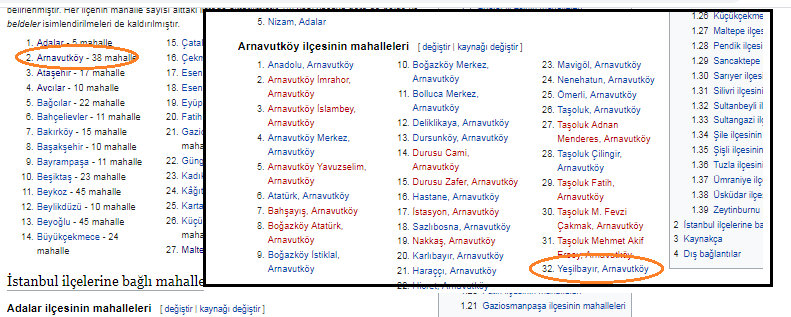

The Wikipedia page says there are 782 Neighboorhoods, but the neighborhood list in th below of the list contradicts with this description. In this special analysis, I will analyze only 837 regions belonging to these boroughs

In [ ]:
df.groupby('Borough').count()

,Neighborhood
Borough,
Adalar,5
Arnavutköy,32
Ataşehir,17
Avcılar,10
Bahçelievler,11
Bakırköy,15
Bayrampaşa,11
Bağcılar,22
Başakşehir,10


### 2.1.2 Get the latitude and longitude values of İstanbul

In [ ]:
df_lat_long = pd.DataFrame() 
df_empty = pd.DataFrame()
locator = Nominatim(user_agent="myGeocoder")
for x, y in zip( df['Borough'],df['Neighborhood']):
  location = locator.geocode('{} {}/İstanbul'.format(y,x))
  if(location == None):
    df_temp_empty = pd.DataFrame(data=[[x,y]])
    df_empty = pd.concat([df_empty,df_temp_empty])
    continue
  longitude = location.longitude
  latitude = location.latitude
  df_temp = pd.DataFrame(data=[[x,y, latitude, longitude]])
  df_lat_long = pd.concat([df_lat_long, df_temp])

In [ ]:
df_lat_long.columns=['Borough','Neighborhood','Latitude','Longitude']
df_lat_long.reset_index(drop=True,inplace=True)

In [ ]:
df_lat_long.head()

,Borough,Neighborhood,Latitude,Longitude
0,Adalar,Burgazada,40.882124,29.064212
0,Adalar,Heybeliada,40.876259,29.091027
0,Adalar,Kınalıada,40.908452,29.048420
0,Adalar,Maden,40.860802,29.126741
0,Adalar,Nizam,40.857676,29.118957


In [49]:
#df_lat_long.to_pickle("data.pkl") #save the dataframe ##/content/data
df_lat_long = pd.read_pickle("data.pkl")

In [ ]:
df_empty.shape #54 neighborhoods' coordinates could not be found, i will omit these neighborhoods

(54, 2)

In [ ]:
df_lat_long.shape #Analysis will continue with 783 neighborhoods

(783, 4)

In [ ]:
len(df_lat_long["Borough"].unique()) #All 39 Boroughs will be covered

39

### 2.1.3 Use Foursquare API to get Venue Data


In [ ]:
CLIENT_ID =  #  Foursquare ID is hidden
CLIENT_SECRET = # Foursquare Secret is hidden
ACCESS_TOKEN =  #  FourSquare Access Token is hidden
VERSION = '20180604'
LIMIT = 100

In [ ]:
df_venue = df_lat_long
df_venue["Neighborhood"] = df_venue['Borough'] +", "+df_venue["Neighborhood"]
df_venue.drop(['Borough'],axis=1,inplace=True)

In [ ]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = req.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [ ]:
#Foursquare API limits cause this call to error
#I could complete this call by dividing neighborhoods, and i combine results. i delete this calls for the sake of simplicity
istanbul_venues = getNearbyVenues(names=df_venue["Neighborhood"],
                                   latitudes=df_venue['Latitude'],
                                   longitudes=df_venue['Longitude']
                                  )

In [ ]:
istanbul_venues

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Ümraniye, Adem Yavuz",41.020734,29.154361,Hasir Cay Bahcesi,41.018059,29.155675,Café
1,"Ümraniye, Adem Yavuz",41.020734,29.154361,starbuck caddebostan,41.021096,29.155739,Coffee Shop
2,"Ümraniye, Adem Yavuz",41.020734,29.154361,FENOMEN PS4 CAFE,41.018182,29.155784,Arcade
3,"Ümraniye, Adem Yavuz",41.020734,29.154361,Blood & İron,41.017630,29.154784,Gym
4,"Ümraniye, Adem Yavuz",41.020734,29.154361,Asmalı Konak,41.017654,29.156064,Palace
...,...,...,...,...,...,...,...
26300,"Tuzla, Yayla",40.832959,29.308593,öz anadolu sofrası,40.830177,29.310943,Steakhouse
26301,"Tuzla, Yayla",40.832959,29.308593,Oruç Market,40.828960,29.306056,Grocery Store
26302,"Tuzla, Yayla",40.832959,29.308593,Göçmen Börek,40.836010,29.305415,Borek Place
26303,"Tuzla, Yayla",40.832959,29.308593,şehzadem,40.828700,29.307082,Café


In [8]:
#istanbul_venues.to_pickle("venues.pkl") #save the dataframe 
istanbul_venues = pd.read_pickle("venues.pkl")

# 3. Methodology <a class="anchor" id="chapter3"></a>

In [9]:
istanbul_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Ümraniye, Adem Yavuz",41.020734,29.154361,Hasir Cay Bahcesi,41.018059,29.155675,Café
1,"Ümraniye, Adem Yavuz",41.020734,29.154361,starbuck caddebostan,41.021096,29.155739,Coffee Shop
2,"Ümraniye, Adem Yavuz",41.020734,29.154361,FENOMEN PS4 CAFE,41.018182,29.155784,Arcade
3,"Ümraniye, Adem Yavuz",41.020734,29.154361,Blood & İron,41.017630,29.154784,Gym
4,"Ümraniye, Adem Yavuz",41.020734,29.154361,Asmalı Konak,41.017654,29.156064,Palace


In [ ]:
len(istanbul_venues['Neighborhood'].unique()) 
# There are 775 different neighborhoods resulted after Foursquare explore 

775

In [ ]:
len(istanbul_venues['Neighborhood'].str.split(",",expand=True)[0].unique()) 
#There are 39 differen Boroughs, which comprimises all borough of İstanbul resulted after Foursquare explore

39

## 3.1 Analyze each neighboorhood by finding most common venue category 

Get dummies of categorical data "Venue Category"

In [10]:
# one hot encoding
istanbul_onehot = pd.get_dummies(istanbul_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
istanbul_onehot['Neighborhood'] = istanbul_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [istanbul_onehot.columns[-1]] + list(istanbul_onehot.columns[:-1])
istanbul_onehot = istanbul_onehot[fixed_columns]

istanbul_onehot.head()

,Çöp Şiş Place,ATM,Accessories Store,Advertising Agency,Afghan Restaurant,African Restaurant,Airport,Airport Food Court,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Amphitheater,Antique Shop,Apres Ski Bar,Aquarium,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Art Studio,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Assisted Living,Athletics & Sports,Auditorium,Austrian Restaurant,Auto Dealership,Auto Garage,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,...,Tour Provider,Tourist Information Center,Toy / Game Store,Track,Track Stadium,Trail,Train Station,Tram Station,Transportation Service,Travel Agency,Tree,Tunnel,Turkish Coffeehouse,Turkish Home Cooking Restaurant,Turkish Restaurant,Turşucu,University,Vacation Rental,Vegetarian / Vegan Restaurant,Veterinarian,Video Game Store,Video Store,Village,Vineyard,Volleyball Court,Warehouse Store,Watch Shop,Water Park,Waterfront,Wedding Hall,Whisky Bar,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yemeni Restaurant,Yoga Studio,Zoo,Zoo Exhibit
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Group all row by neighborhood and get the mean of frequency of each venue category

In [11]:
istanbul_grouped = istanbul_onehot.groupby('Neighborhood').mean().reset_index()
istanbul_grouped.head()

,Neighborhood,Çöp Şiş Place,ATM,Accessories Store,Advertising Agency,Afghan Restaurant,African Restaurant,Airport,Airport Food Court,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Amphitheater,Antique Shop,Apres Ski Bar,Aquarium,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Art Studio,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Assisted Living,Athletics & Sports,Auditorium,Austrian Restaurant,Auto Dealership,Auto Garage,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,...,Tour Provider,Tourist Information Center,Toy / Game Store,Track,Track Stadium,Trail,Train Station,Tram Station,Transportation Service,Travel Agency,Tree,Tunnel,Turkish Coffeehouse,Turkish Home Cooking Restaurant,Turkish Restaurant,Turşucu,University,Vacation Rental,Vegetarian / Vegan Restaurant,Veterinarian,Video Game Store,Video Store,Village,Vineyard,Volleyball Court,Warehouse Store,Watch Shop,Water Park,Waterfront,Wedding Hall,Whisky Bar,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yemeni Restaurant,Yoga Studio,Zoo,Zoo Exhibit
0,"Adalar, Burgazada",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.020833,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.020833,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,"Adalar, Heybeliada",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.052632,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,"Adalar, Kınalıada",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0625,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.062500,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,"Adalar, Maden",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.071429,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,"Adalar, Nizam",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Get the most common Venue Category for each category

In [12]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [32]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = istanbul_grouped['Neighborhood']

for ind in np.arange(istanbul_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(istanbul_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Adalar, Burgazada",Seafood Restaurant,Café,Beach,Boat or Ferry,Tea Room,Hotel,Coffee Shop,Fast Food Restaurant,Bookstore,Restaurant
1,"Adalar, Heybeliada",Café,Mountain,Scenic Lookout,Harbor / Marina,Bed & Breakfast,Boat or Ferry,Hotel,Bike Trail,Surf Spot,Beach
2,"Adalar, Kınalıada",Beach,Boat or Ferry,Beach Bar,Pool,Forest,Church,Athletics & Sports,Café,Harbor / Marina,Trail
3,"Adalar, Maden",Historic Site,Nature Preserve,Motel,Park,Trail,Harbor / Marina,Beach,Bed & Breakfast,Café,Restaurant
4,"Adalar, Nizam",Hotel,Café,Road,Bed & Breakfast,Forest,Restaurant,Harbor / Marina,Tea Room,Mountain,Zoo Exhibit


Now, data is ready fo clustering

## 3.2 Clustering and Segmentation

I will use KMeans as Clustering algorithm.
Only numerical columns can be used for Clustering, so drop Neighborhood column

In [33]:
istanbul_grouped_clustering = istanbul_grouped.drop('Neighborhood', 1)

In [34]:
istanbul_grouped_clustering.head()

,Çöp Şiş Place,ATM,Accessories Store,Advertising Agency,Afghan Restaurant,African Restaurant,Airport,Airport Food Court,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Amphitheater,Antique Shop,Apres Ski Bar,Aquarium,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Art Studio,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Assisted Living,Athletics & Sports,Auditorium,Austrian Restaurant,Auto Dealership,Auto Garage,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,...,Tour Provider,Tourist Information Center,Toy / Game Store,Track,Track Stadium,Trail,Train Station,Tram Station,Transportation Service,Travel Agency,Tree,Tunnel,Turkish Coffeehouse,Turkish Home Cooking Restaurant,Turkish Restaurant,Turşucu,University,Vacation Rental,Vegetarian / Vegan Restaurant,Veterinarian,Video Game Store,Video Store,Village,Vineyard,Volleyball Court,Warehouse Store,Watch Shop,Water Park,Waterfront,Wedding Hall,Whisky Bar,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yemeni Restaurant,Yoga Studio,Zoo,Zoo Exhibit
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.020833,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.020833,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.052632,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0625,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.062500,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.071429,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Elbow Method is used for finding k for KMeans. 
Elbow Method is a heuroistic used in detemining number of clusters in data [1].

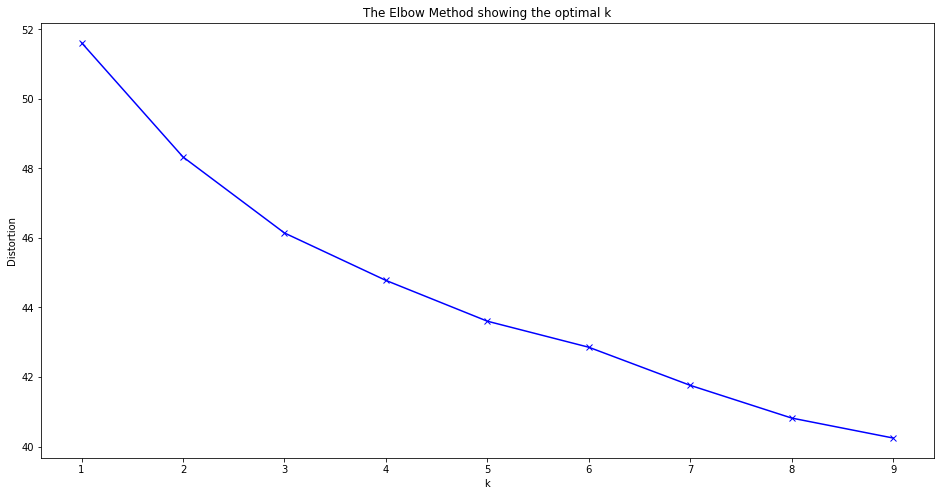

In [26]:
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(istanbul_grouped_clustering)
    distortions.append(kmeanModel.inertia_)
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

[2] If the line chart looks like an arm, then the “elbow” (the point of inflection on the curve) is the best value of k. The “arm” can be either up or down, but if there is a strong inflection point, it is a good indication that the underlying model fits best at that point.

Our Elbow Method chart does not give an obvious "elbow point", but 3 or 4 can be a good optimal value for choosing the number of k. I will continue with 3

In [35]:
# set number of clusters
num_clusters = 3


# run k-means clustering
kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(istanbul_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([1, 1, 2, 2, 1, 2, 2, 2, 1, 1], dtype=int32)

In [36]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)


In [37]:
neighborhoods_venues_sorted.head()

,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,1,"Adalar, Burgazada",Seafood Restaurant,Café,Beach,Boat or Ferry,Tea Room,Hotel,Coffee Shop,Fast Food Restaurant,Bookstore,Restaurant
1,1,"Adalar, Heybeliada",Café,Mountain,Scenic Lookout,Harbor / Marina,Bed & Breakfast,Boat or Ferry,Hotel,Bike Trail,Surf Spot,Beach
2,2,"Adalar, Kınalıada",Beach,Boat or Ferry,Beach Bar,Pool,Forest,Church,Athletics & Sports,Café,Harbor / Marina,Trail
3,2,"Adalar, Maden",Historic Site,Nature Preserve,Motel,Park,Trail,Harbor / Marina,Beach,Bed & Breakfast,Café,Restaurant
4,1,"Adalar, Nizam",Hotel,Café,Road,Bed & Breakfast,Forest,Restaurant,Harbor / Marina,Tea Room,Mountain,Zoo Exhibit


In [53]:
istanbul_merged = df_lat_long
istanbul_merged["Neighborhood"]= istanbul_merged['Borough'] +", "+istanbul_merged["Neighborhood"]


istanbul_merged = istanbul_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')


#istanbul_merged.head() # check the last columns!
neighborhoods_venues_sorted

,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,1,"Adalar, Burgazada",Seafood Restaurant,Café,Beach,Boat or Ferry,Tea Room,Hotel,Coffee Shop,Fast Food Restaurant,Bookstore,Restaurant
1,1,"Adalar, Heybeliada",Café,Mountain,Scenic Lookout,Harbor / Marina,Bed & Breakfast,Boat or Ferry,Hotel,Bike Trail,Surf Spot,Beach
2,2,"Adalar, Kınalıada",Beach,Boat or Ferry,Beach Bar,Pool,Forest,Church,Athletics & Sports,Café,Harbor / Marina,Trail
3,2,"Adalar, Maden",Historic Site,Nature Preserve,Motel,Park,Trail,Harbor / Marina,Beach,Bed & Breakfast,Café,Restaurant
4,1,"Adalar, Nizam",Hotel,Café,Road,Bed & Breakfast,Forest,Restaurant,Harbor / Marina,Tea Room,Mountain,Zoo Exhibit
...,...,...,...,...,...,...,...,...,...,...,...,...
770,2,"Şişli, Paşa",Park,Bakery,Lounge,Kofte Place,Spa,Motorcycle Shop,Fast Food Restaurant,Snack Place,Mediterranean Restaurant,Martial Arts School
771,2,"Şişli, Teşvikiye",Restaurant,Café,Coffee Shop,Hotel,Gym,Lounge,Concert Hall,Boutique,Clothing Store,Nightclub
772,1,"Şişli, Yayla",Café,Bakery,Snack Place,Kebab Restaurant,Turkish Restaurant,Borek Place,Grocery Store,Meyhane,Tantuni Restaurant,Middle Eastern Restaurant
773,2,"Şişli, İnönü",Hotel,Café,Pool,Turkish Restaurant,Mediterranean Restaurant,Italian Restaurant,Hostel,Kebab Restaurant,Nightclub,Coffee Shop


# 4. Results <a class="anchor" id="chapter4"></a>

#### Cluster 1 (**Farm Cluster**)

In [54]:
cluster1 = istanbul_merged.loc[istanbul_merged['Cluster Labels'] == 0, istanbul_merged.columns[[1] + list(range(5, istanbul_merged.shape[1]))]]
cluster1

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Arnavutköy, Deliklikaya",Construction & Landscaping,Women's Store,Garden,Steakhouse,Park,Farm,Event Service,Factory,Fabric Shop,Exhibit
0,"Arnavutköy, Dursunköy",Airport Terminal,Garden,Park,Smoke Shop,Dive Bar,Farm,Zoo Exhibit,Factory,Fabric Shop,Exhibit
0,"Arnavutköy, Nakkaş",Farm,Construction & Landscaping,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,English Restaurant,Entertainment Service,Escape Room,Ethiopian Restaurant,Event Service
0,"Beykoz, Baklacı",Farm,Breakfast Spot,Steakhouse,Café,Fried Chicken Joint,BBQ Joint,Entertainment Service,Escape Room,English Restaurant,Farmers Market
0,"Beykoz, Tokatköy",Bus Stop,Mountain,Coffee Shop,Turkish Restaurant,Farm,Auto Workshop,Entertainment Service,Escape Room,Ethiopian Restaurant,Event Service
0,"Beylikdüzü, Dereağzı",Farm,Botanical Garden,Garden,Summer Camp,Cosmetics Shop,Filipino Restaurant,Entertainment Service,Escape Room,Ethiopian Restaurant,Event Service
0,"Büyükçekmece, 19 Mayıs",Farm,Lake,Bakery,Café,Bistro,Fabric Shop,Farmers Market,Falafel Restaurant,Factory,Exhibit
0,"Çekmeköy, Sırapınar",Steakhouse,Fried Chicken Joint,Kofte Place,Farm,Comfort Food Restaurant,Electronics Store,English Restaurant,Entertainment Service,Escape Room,Farmers Market
0,"Silivri, Değirmenköy İsmetpaşa",Farm,Brewery,Mountain,Zoo Exhibit,Event Space,Falafel Restaurant,Factory,Fabric Shop,Exhibit,Event Service
0,"Silivri, Küçük Kılıçlı",Steakhouse,Café,Park,Farm,Campground,Zoo Exhibit,Event Space,Factory,Fabric Shop,Exhibit


There are 22 neighborhoods in Cluster0

In [55]:
cluster1.shape

(22, 11)

1st Most Common Venue of them mostly "Farm"

In [56]:
cluster1["1st Most Common Venue"].value_counts()

Farm                          12
Steakhouse                     2
Tea Room                       2
Arcade                         1
Plaza                          1
Construction & Landscaping     1
Café                           1
Bus Stop                       1
Airport Terminal               1
Name: 1st Most Common Venue, dtype: int64

I will call Cluster1 as  "**Farm Cluster**"

#### Cluster 2 (**Café Cluster**)

In [57]:
cluster2 = istanbul_merged.loc[istanbul_merged['Cluster Labels'] == 1, istanbul_merged.columns[[1] + list(range(5, istanbul_merged.shape[1]))]]
cluster2

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Adalar, Burgazada",Seafood Restaurant,Café,Beach,Boat or Ferry,Tea Room,Hotel,Coffee Shop,Fast Food Restaurant,Bookstore,Restaurant
0,"Adalar, Heybeliada",Café,Mountain,Scenic Lookout,Harbor / Marina,Bed & Breakfast,Boat or Ferry,Hotel,Bike Trail,Surf Spot,Beach
0,"Adalar, Nizam",Hotel,Café,Road,Bed & Breakfast,Forest,Restaurant,Harbor / Marina,Tea Room,Mountain,Zoo Exhibit
0,"Arnavutköy, Boğazköy Atatürk",Café,BBQ Joint,Wings Joint,Restaurant,Scenic Lookout,Tea Room,Park,Steakhouse,Eastern European Restaurant,Electronics Store
0,"Arnavutköy, Boğazköy İstiklal",Café,BBQ Joint,Wings Joint,Restaurant,Scenic Lookout,Tea Room,Park,Steakhouse,Eastern European Restaurant,Electronics Store
...,...,...,...,...,...,...,...,...,...,...,...
0,"Esenyurt, Şehitler",Café,Electronics Store,Pizza Place,Convenience Store,Market,Park,Bagel Shop,Camera Store,Pharmacy,Clothing Store
0,"Esenyurt, Talatpaşa",Café,Steakhouse,Turkish Restaurant,Smoke Shop,Garden,Bakery,Park,Construction & Landscaping,Market,Diner
0,"Esenyurt, Üçevler",Café,Gym / Fitness Center,Turkish Restaurant,Convenience Store,Restaurant,Breakfast Spot,Borek Place,Tea Room,Smoke Shop,Candy Store
0,"Esenyurt, Yeşilkent",Café,Gym / Fitness Center,Gym,Park,Shopping Mall,Water Park,Pool,Kebab Restaurant,Pizza Place,Fish & Chips Shop


In [58]:
cluster2["1st Most Common Venue"].value_counts()

Café                  268
Turkish Restaurant      6
Convenience Store       6
Seafood Restaurant      5
Park                    3
Gym                     2
Concert Hall            2
Movie Theater           1
Restaurant              1
Garden                  1
Tea Room                1
Paintball Field         1
Pizza Place             1
Hotel                   1
Plaza                   1
Lake                    1
Soccer Stadium          1
Bus Stop                1
Surf Spot               1
Hospital                1
Farm                    1
Kofte Place             1
Name: 1st Most Common Venue, dtype: int64

In [ ]:
cluster2["2nd Most Common Venue"].value_counts()

Cluster2's neighborhoods' first most common venue category is "Cafe", second most commmon venue is "Turkish Restaurant"

#### Cluster 3 (**Restaurant & Cafe Cluster**)



In [59]:
cluster3 = istanbul_merged.loc[istanbul_merged['Cluster Labels'] == 2, istanbul_merged.columns[[1] + list(range(5, istanbul_merged.shape[1]))]]
cluster3

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Adalar, Kınalıada",Beach,Boat or Ferry,Beach Bar,Pool,Forest,Church,Athletics & Sports,Café,Harbor / Marina,Trail
0,"Adalar, Maden",Historic Site,Nature Preserve,Motel,Park,Trail,Harbor / Marina,Beach,Bed & Breakfast,Café,Restaurant
0,"Arnavutköy, Anadolu",Steakhouse,Mobile Phone Shop,Shopping Mall,Concert Hall,Kofte Place,Music Venue,Convenience Store,Buffet,Burrito Place,Fast Food Restaurant
0,"Arnavutköy, Arnavutköy İmrahor",Airport Service,Rental Car Location,Airport Terminal,Bus Stop,Mobile Phone Shop,Construction & Landscaping,Café,Bagel Shop,Roof Deck,Heliport
0,"Arnavutköy, Atatürk",Cigkofte Place,Department Store,Buffet,Middle Eastern Restaurant,Café,Soccer Field,Arcade,Sports Club,Gym / Fitness Center,Stadium
...,...,...,...,...,...,...,...,...,...,...,...
0,"Esenyurt, Selahaddin Eyyubi",Plaza,Racetrack,Gym / Fitness Center,Restaurant,Diner,Park,Café,Soccer Stadium,Food Truck,Furniture / Home Store
0,"Esenyurt, Süleymaniye",Café,Big Box Store,Restaurant,Pharmacy,Convenience Store,Tea Room,Carpet Store,Scenic Lookout,Cave,Tailor Shop
0,"Esenyurt, Turgut Özal",Café,Coffee Shop,Shoe Store,Hotel,Sporting Goods Shop,Recreation Center,Clothing Store,Paper / Office Supplies Store,Turkish Home Cooking Restaurant,Dive Spot
0,"Esenyurt, Yenikent",Café,Restaurant,Clothing Store,Doner Restaurant,Shopping Mall,Water Park,Soup Place,Gym / Fitness Center,Eastern European Restaurant,Meyhane


Cluster3 has %57 of all the neighborhoods of Istanbul, (446 of 775) . Cluster3 is very likely to Cluster2; In most of the neighborhoods, most common venue category is Cafe as Cluster2. However, second most common venue category is also Cafe in Cluster3.  I will analyze these two clusters in more detail

In [41]:
 #most common venue categories of cluster3
 [cluster3.iloc[:,x].value_counts() for x in range(1,11)]

[Series([], Name: 1st Most Common Venue, dtype: int64),
 Series([], Name: 2nd Most Common Venue, dtype: int64),
 Series([], Name: 3rd Most Common Venue, dtype: int64),
 Series([], Name: 4th Most Common Venue, dtype: int64),
 Series([], Name: 5th Most Common Venue, dtype: int64),
 Series([], Name: 6th Most Common Venue, dtype: int64),
 Series([], Name: 7th Most Common Venue, dtype: int64),
 Series([], Name: 8th Most Common Venue, dtype: int64),
 Series([], Name: 9th Most Common Venue, dtype: int64),
 Series([], Name: 10th Most Common Venue, dtype: int64)]

In [84]:
 #most common venue categories of cluster2
 [cluster2.iloc[:,x].value_counts() for x in range(1,11)]

[Café                  268
 Convenience Store       6
 Turkish Restaurant      6
 Seafood Restaurant      5
 Park                    3
 Gym                     2
 Concert Hall            2
 Soccer Stadium          1
 Surf Spot               1
 Restaurant              1
 Paintball Field         1
 Kofte Place             1
 Garden                  1
 Plaza                   1
 Bus Stop                1
 Hospital                1
 Farm                    1
 Movie Theater           1
 Pizza Place             1
 Hotel                   1
 Tea Room                1
 Lake                    1
 Name: 1st Most Common Venue, dtype: int64, Turkish Restaurant            40
 Restaurant                    29
 Café                          24
 Park                          22
 Coffee Shop                   16
                               ..
 Construction & Landscaping     1
 Comfort Food Restaurant        1
 Comedy Club                    1
 Trail                          1
 College Quad          

Let's visualize the results

In [60]:
latitude = istanbul_merged['Latitude'].mean()
longitude = istanbul_merged['Longitude'].mean()

In [61]:
istanbul_merged = istanbul_merged.dropna(how='any')

In [63]:
# create map
map_clusters = folium.Map(location=[latitude,longitude],zoom_start=10)
cluster_label = ["Farm", "Cafe", "Restaurant&Cafe"]
# set color scheme for the clusters
x = np.arange(num_clusters)
ys = [i + x + (i*x)**2 for i in range(num_clusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, neighbourhood, cluster in zip(istanbul_merged['Latitude'], istanbul_merged['Longitude'], istanbul_merged['Neighborhood'], istanbul_merged['Cluster Labels'].astype(int)):
    label = folium.Popup(' Cluster ' + str(cluster+1) + "-"+cluster_label[cluster], parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

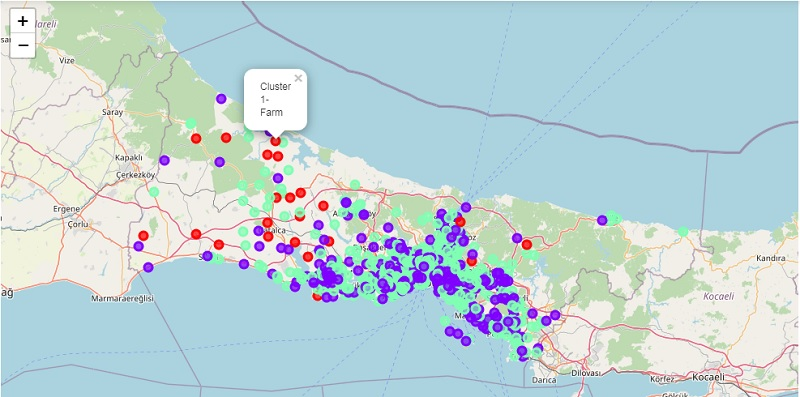

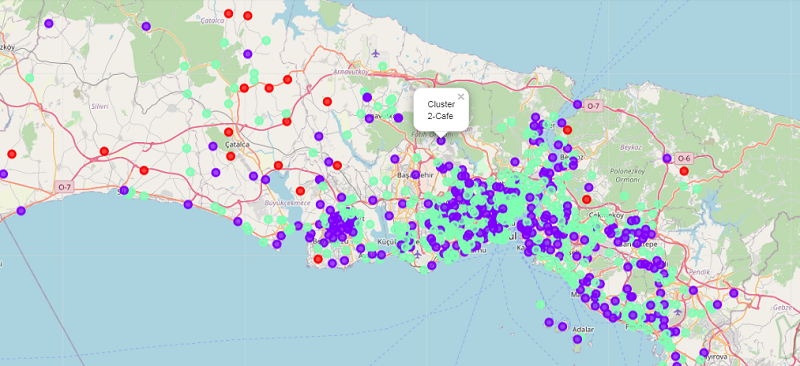

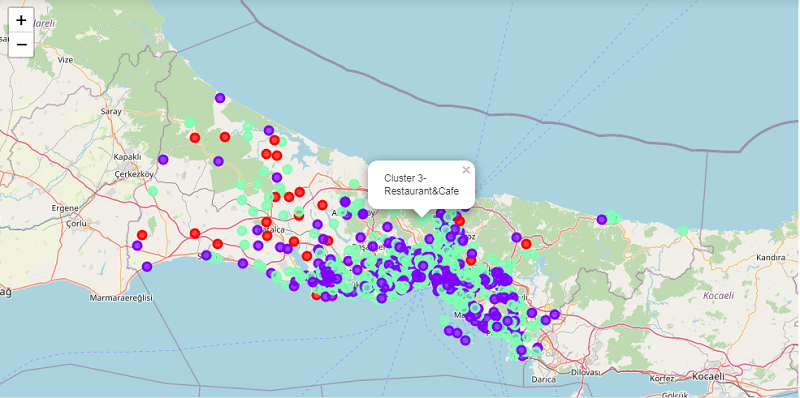

# 5. Discussion <a class="anchor" id="chapter5"></a>

Based on these results, cluster0 is the most clear segment. With only 22 neighborhoods, it is easy to see that natural places like Farm, Garden consists most of these neighborhoods.
However, Cluster2 and Cluster3 were almost homogenous having mostly Cafe and Restaurants venue categories. However, in Cluster2, 1.st most common venue category of %87 of neignborhoods (268 out of 377) was Cafe, and also other most common or second common one was also cafe, so i called this cluster as Cafe only.
According to these results, it can be also conclude that other than these 22 neighborhoods of cluster0, Istanbul neighborhoods are same in terms of venue categories.

# 6. Conclusion <a class="anchor" id="chapter6"></a>

In conclusion, if we turn to our business problem, a homeseeker who wants to be distance from city crowd and noise and willing to live close to nature, he/she can move neighborhoods of Cluster0. In other cases, he/she can choose cluster2 and cluster3 neighborhoods. cluster2 neighborhoods are mostly have Cafe, cluster3 have mostly Cafe and Restaurant. Other than these most common venue categories, according to special needs these two cluster neighborhoods must be examined seperately. For example, if the resident needs a gym in his neighborhoods, he/she can search neighborhoods with gym, but there is not a segment of these category.

# Referrences





1.   [1] [Wikipedia, Elbow Method (clustering)](https://en.wikipedia.org/wiki/Elbow_method_(clustering))
2.   [2] [Elbow Method](https://www.scikit-yb.org/en/latest/api/cluster/elbow.html#:~:text=K%2Dmeans%20is%20a%20simple,number%20(k)%20of%20clusters.&text=The%20elbow%20method%20runs%20k,average%20score%20for%20all%20clusters.)


